# Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import infomap           as im
import matplotlib.pyplot as plt
import networkx          as nx
import numpy             as np
import pandas            as pd
import seaborn           as sb

from analysis import *
from os.path import exists

In [2]:
colours = ["windows blue", "amber", "pale red", "greyish", "faded green", "dusty purple", "orange"]

sb.set()
sb.set_style("whitegrid", {'grid.linestyle': '--'}),
sb.set_palette(sb.xkcd_palette(colours))

# Load data

In [3]:
!mkdir -p ../data
!curl https://networks.skewed.de/net/power/files/power.csv.zip > ../data/power.zip
!unzip -p ../data/power.zip edges.csv > ../data/power.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 91843  100 91843    0     0   227k      0 --:--:-- --:--:-- --:--:--  227k


In [4]:
G_raw = nx.Graph()

with open("../data/power.csv", "r") as fh:
    fh.readline()
    for line in fh:
        u,v = line.strip().split(",")
        G_raw.add_edge(u,v)

G = G_raw.subgraph(max(nx.connected_components(G_raw), key=len)).copy()

In [5]:
G_dir = nx.DiGraph()
G_dir.add_nodes_from(G.nodes)
for (u,v) in G.edges:
    G_dir.add_edge(u,v)
    G_dir.add_edge(v,u)

In [6]:
with open("../data/power.edgelist", "w") as fh:
    for (u,v) in G.edges:
        fh.write(f"{u} {v}\n")

# Infer community structure with Infomap

In [7]:
# with unrecorded link teleportation
cluster_data = "../results/power.tree"
infomap = im.Infomap( silent       = True
                    , num_trials   = 1000
                    , directed     = False
                    , two_level    = True
                    , seed         = 42
                    , no_infomap   = exists(cluster_data)
                    , cluster_data = cluster_data if exists(cluster_data) else None
                    )
node_mapping = infomap.add_networkx_graph(G)
infomap.run()

if not exists(cluster_data):
    infomap.write_tree(cluster_data)

communities = mkPartition(infomap)
community_assignments = mkCommunityAssignments(infomap)

In [8]:
# with recorded node teleportation
cluster_data_pr = "../results/power.pr.tree"
args = [ "--silent"
       , "--num-trials 1000"
       , "--directed"
       , "--two-level"
       , "--seed 42"
       , "--to-nodes"
       , "--recorded-teleportation"
       ]
if exists(cluster_data_pr):
    args.append("--no-infomap")
    args.append(f"--cluster-data {cluster_data_pr}")

infomap_pr = im.Infomap(" ".join(args))
node_mapping_pr = infomap_pr.add_networkx_graph(G_dir)
infomap_pr.run()

if not exists(cluster_data_pr):
    infomap_pr.write_tree(cluster_data_pr)

communities_pr = mkPartition(infomap_pr)
community_assignments_pr = mkCommunityAssignments(infomap_pr)

# Some data statistics

In [9]:
showStats(G, community_assignments, communities)

#nodes:       4941
#edges:       6594
#communities: 428
#eff. comm.:  377
<k>:          2.669
<k²>:         10.333
transitivity: 0.103
mixing:       0.163
λth:          0.348


In [10]:
showStats(G, community_assignments_pr, communities_pr)

#nodes:       4941
#edges:       6594
#communities: 465
#eff. comm.:  416
<k>:          2.669
<k²>:         10.333
transitivity: 0.103
mixing:       0.177
λth:          0.348


# Calculate / load centrality scores

In [11]:
results_file = "../results/power.csv"

if not exists(results_file):
    # Community Hub Bridge
    com_hb_ranks    = calculate_community_hub_bridge_ranks(G = G, communities = communities,    community_assignments = community_assignments)
    com_hb_ranks_pr = calculate_community_hub_bridge_ranks(G = G, communities = communities_pr, community_assignments = community_assignments_pr)
    
    # Community-based Centrality
    com_bc_ranks    = calculate_community_based_centrality_ranks(G = G, communities = communities,    community_assignments = community_assignments)
    com_bc_ranks_pr = calculate_community_based_centrality_ranks(G = G, communities = communities_pr, community_assignments = community_assignments_pr)

    # Modularity Vitality
    mod_vit_ranks    = calculate_modularity_vitality_ranks(G = G, partition = list(communities.values()))
    mod_vit_ranks_pr = calculate_modularity_vitality_ranks(G = G, partition = list(communities_pr.values()))
    
    # Map Equation Centrality
    mec_ranks    = [ node for node, _score in sorted( [ (node_mapping[node.node_id], node.modular_centrality) for node in infomap.iterLeafNodes() ]
                                                    , key     = second
                                                    , reverse = True
                                                    )]
    mec_ranks_pr = [ node for node, _score in sorted( [ (node_mapping_pr[node.node_id], node.modular_centrality) for node in infomap_pr.iterLeafNodes() ]
                                                    , key     = second
                                                    , reverse = True
                                                    )]
    
    # Degree and betweenness centrality
    dc_ranks      = [ node for node, _score in sorted( nx.algorithms.centrality.degree_centrality(G).items()
                                                     , key     = second
                                                     , reverse = True
                                                     )]
    between_ranks = [ node for node, _score in sorted( nx.algorithms.centrality.betweenness_centrality(G).items()
                                                     , key     = second
                                                     , reverse = True
                                                     )]
    
    results = pd.DataFrame()
    results.index = G.nodes

    results["map equation centrality rank"]       = toRanking(mec_ranks,        results.index)
    results["map equation centrality rank pr"]    = toRanking(mec_ranks_pr,     results.index)
    results["modularity vitality rank"]           = toRanking(mod_vit_ranks,    results.index)
    results["modularity vitality rank pr"]        = toRanking(mod_vit_ranks_pr, results.index)
    results["community hub-bridge rank"]          = toRanking(com_hb_ranks,     results.index)
    results["community hub-bridge rank pr"]       = toRanking(com_hb_ranks_pr,  results.index)
    results["community-based centrality rank"]    = toRanking(com_bc_ranks,     results.index)
    results["community-based centrality rank pr"] = toRanking(com_bc_ranks_pr,  results.index)
    results["degree centrality rank"]             = toRanking(dc_ranks,         results.index)
    results["betweenness centrality rank"]        = toRanking(between_ranks,    results.index)

    results.to_csv(results_file)

else:
    results = pd.read_csv(results_file, index_col = 0)

    mec_ranks         = mkRanks(results["map equation centrality rank"])
    mec_ranks_pr      = mkRanks(results["map equation centrality rank pr"])
    mod_vit_ranks     = mkRanks(results["modularity vitality rank"])
    mod_vit_ranks_pr  = mkRanks(results["modularity vitality rank pr"])
    com_hb_ranks      = mkRanks(results["community hub-bridge rank"])
    com_hb_ranks_pr   = mkRanks(results["community hub-bridge rank pr"])
    com_bc_ranks      = mkRanks(results["community-based centrality rank"])
    com_bc_ranks_pr   = mkRanks(results["community-based centrality rank pr"])
    dc_ranks          = mkRanks(results["degree centrality rank"])
    between_ranks     = mkRanks(results["betweenness centrality rank"])

# SIR

In [12]:
if not exists("../data/power.spreading_power"):
    !../spreading-power-exe --input ../data/power.edgelist \
                            --output ../data/power.spreading_power \
                            --seed 42 \
                            --iterations 1000

In [13]:
spreading_power = dict()
with open("../data/power.spreading_power") as fh:
    for line in fh:
        node, power = line.strip().split(" ")
        spreading_power[node] = float(power)

In [14]:
sir_ranks = [ node for node, _score 
              in sorted( spreading_power.items()
                       , key     = lambda p: p[1]
                       , reverse = True
                       )
            ]

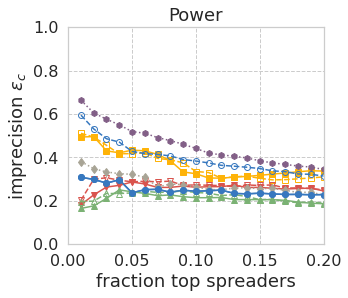

In [15]:
node_fractions = [0.01 * p for p in range (1,21)]

mec_x,        mec_y        = zip(*get_imperfections(mec_ranks,         sir_ranks, spreading_power, node_fractions = node_fractions))
mec_pr_x,     mec_pr_y     = zip(*get_imperfections(mec_ranks_pr,      sir_ranks, spreading_power, node_fractions = node_fractions))
mod_vit_x,    mod_vit_y    = zip(*get_imperfections(mod_vit_ranks,     sir_ranks, spreading_power, node_fractions = node_fractions))
mod_vit_pr_x, mod_vit_pr_y = zip(*get_imperfections(mod_vit_ranks_pr,  sir_ranks, spreading_power, node_fractions = node_fractions))
com_hb_x,     com_hb_y     = zip(*get_imperfections(com_hb_ranks,      sir_ranks, spreading_power, node_fractions = node_fractions))
com_hb_pr_x,  com_hb_pr_y  = zip(*get_imperfections(com_hb_ranks_pr,   sir_ranks, spreading_power, node_fractions = node_fractions))
com_bc_x,     com_bc_y     = zip(*get_imperfections(com_bc_ranks,      sir_ranks, spreading_power, node_fractions = node_fractions))
com_bc_pr_x,  com_bc_pr_y  = zip(*get_imperfections(com_bc_ranks_pr,   sir_ranks, spreading_power, node_fractions = node_fractions))
dc_x,         dc_y         = zip(*get_imperfections(dc_ranks,          sir_ranks, spreading_power, node_fractions = node_fractions))
between_x,    between_y    = zip(*get_imperfections(between_ranks,     sir_ranks, spreading_power, node_fractions = node_fractions))

fig = plt.figure(figsize = (5,4.3))

plt.plot(mec_x,        mec_y,        marker = "o", color = sb.color_palette()[0], linestyle = "-", label = "map equation centrality")
plt.plot(mod_vit_x,    mod_vit_y,    marker = "s", color = sb.color_palette()[1], label = "modularity vitality")
plt.plot(mod_vit_pr_x, mod_vit_pr_y, marker = "s", color = sb.color_palette()[1], linestyle = "--", fillstyle = "none")
plt.plot(com_hb_x,     com_hb_y,     marker = "v", color = sb.color_palette()[2], label = "community hub-bridge")
plt.plot(com_hb_pr_x,  com_hb_pr_y,  marker = "v", color = sb.color_palette()[2], linestyle = "--", fillstyle = "none")
plt.plot(com_bc_x,     com_bc_y,     marker = "^", color = sb.color_palette()[4], label = "comm.-based centrality")
plt.plot(com_bc_pr_x,  com_bc_pr_y,  marker = "^", color = sb.color_palette()[4], linestyle = "--", fillstyle = "none")
plt.plot(dc_x,         dc_y,         marker = "d", color = sb.color_palette()[3], linestyle = "dotted", label = "degree centrality")
plt.plot(between_x,    between_y,    marker = "h", color = sb.color_palette()[5], linestyle = "dotted", label = "betweenness centrality")
plt.plot(mec_x,        mec_y,        marker = "o", color = sb.color_palette()[0])
plt.plot(mec_pr_x,     mec_pr_y,     marker = "o", color = sb.color_palette()[0], linestyle = "--", fillstyle = "none")

plt.title("Power", fontsize = 18)
plt.ylabel("imprecision $\epsilon_c$", fontsize = 18)
plt.xlabel("fraction top spreaders", fontsize = 18)
plt.xticks([0,0.05,0.1,0.15,0.2], fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlim(0.0, 0.2)
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("../plots/sir-power.pdf")

In [16]:
!pdfcrop ../plots/sir-power.pdf
!mv ../plots/sir-power-crop.pdf ../plots/sir-power.pdf

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../plots/sir-power-crop.pdf'.


# Linear threshold model

In [17]:
fractions  = [0.01 * x for x in range(21)]
thresholds = [0.1  * x for x in range(1,10)]
thresholds = [0.4, 0.5, 0.6]

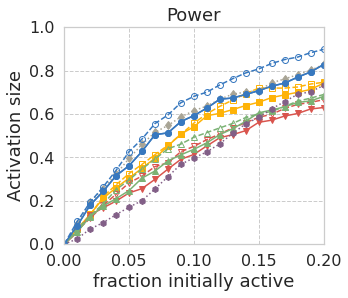

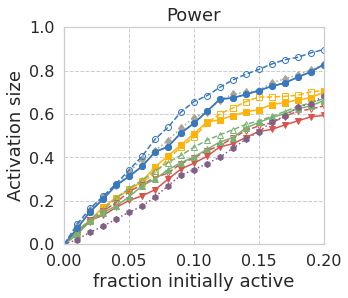

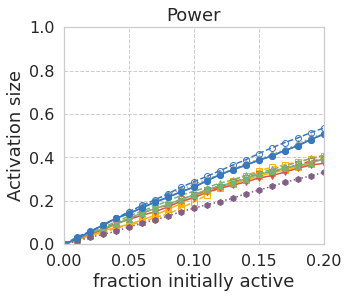

In [18]:
for t in thresholds:
    map_equation_centrality_ys       = []
    map_equation_centrality_pr_ys    = []
    modularity_vitality_ys           = []
    modularity_vitality_pr_ys        = []
    community_hub_bridge_ys          = []
    community_hub_bridge_pr_ys       = []
    community_based_centrality_ys    = []
    community_based_centrality_pr_ys = []
    degree_centrality_ys             = []
    betweenness_centrality_ys        = []

    threshold_gen = lambda: t

    for fraction in fractions:
        num_top = round(fraction * G.number_of_nodes())
        map_equation_centrality_ys.append(cascade(G, initial_active = mec_ranks[:num_top], threshold_gen = threshold_gen))
        map_equation_centrality_pr_ys.append(cascade(G, initial_active = mec_ranks_pr[:num_top], threshold_gen = threshold_gen))
        modularity_vitality_ys.append(cascade(G, initial_active = mod_vit_ranks[:num_top], threshold_gen = threshold_gen))
        modularity_vitality_pr_ys.append(cascade(G, initial_active = mod_vit_ranks_pr[:num_top], threshold_gen = threshold_gen))
        community_hub_bridge_ys.append(cascade(G, initial_active = com_hb_ranks[:num_top], threshold_gen = threshold_gen))
        community_hub_bridge_pr_ys.append(cascade(G, initial_active = com_hb_ranks_pr[:num_top], threshold_gen = threshold_gen))
        community_based_centrality_ys.append(cascade(G, initial_active = com_bc_ranks[:num_top], threshold_gen = threshold_gen))
        community_based_centrality_pr_ys.append(cascade(G, initial_active = com_bc_ranks_pr[:num_top], threshold_gen = threshold_gen))
        degree_centrality_ys.append(cascade(G, initial_active = dc_ranks[:num_top], threshold_gen = threshold_gen))
        betweenness_centrality_ys.append(cascade(G, initial_active = between_ranks[:num_top], threshold_gen = threshold_gen))

    fig = plt.figure(figsize = (5,4.3))

    plt.plot(fractions, map_equation_centrality_ys,       marker = "o", color = sb.color_palette()[0], label = "map eq. centr.")
    plt.plot(fractions, modularity_vitality_ys,           marker = "s", color = sb.color_palette()[1], label = "mod. vit.")
    plt.plot(fractions, modularity_vitality_pr_ys,        marker = "s", color = sb.color_palette()[1], linestyle = "--", fillstyle = "none")
    plt.plot(fractions, community_hub_bridge_ys,          marker = "v", color = sb.color_palette()[2], label = "comm. hub bridge")
    plt.plot(fractions, community_hub_bridge_pr_ys,       marker = "v", color = sb.color_palette()[2], linestyle = "--", fillstyle = "none")
    plt.plot(fractions, community_based_centrality_ys,    marker = "^", color = sb.color_palette()[4], label = "comm.-based centr.")
    plt.plot(fractions, community_based_centrality_pr_ys, marker = "^", color = sb.color_palette()[4], linestyle = "--", fillstyle = "none")
    plt.plot(fractions, degree_centrality_ys,             marker = "d", color = sb.color_palette()[3], linestyle = "dotted")
    plt.plot(fractions, betweenness_centrality_ys,        marker = "h", color = sb.color_palette()[5], linestyle = "dotted")
    plt.plot(fractions, map_equation_centrality_ys,       marker = "o", color = sb.color_palette()[0])
    plt.plot(fractions, map_equation_centrality_pr_ys,    marker = "o", color = sb.color_palette()[0], linestyle = "--", fillstyle = "none")

    plt.title(f"Power", fontsize = 18)
    plt.ylabel("Activation size", fontsize = 18)
    plt.xlabel("fraction initially active", fontsize = 18)
    plt.xticks([0,0.05,0.1,0.15,0.2], fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xlim(0.0, 0.2)
    plt.ylim(0,1.0)
    plt.tight_layout()
    plt.savefig(f"../plots/lt-{t:.1f}-power.pdf")

In [19]:
for t in thresholds:
    s = f"{t:.1f}"
    !pdfcrop ../plots/lt-{s}-power.pdf
    !mv ../plots/lt-{s}-power-crop.pdf ../plots/lt-{s}-power.pdf

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../plots/lt-0.4-power-crop.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../plots/lt-0.5-power-crop.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../plots/lt-0.6-power-crop.pdf'.


# Node distribution

In [20]:
mec_perp        = [ get_distribution_perplexity(communities,    p, mec_ranks)        for p in node_fractions ]
mec_pr_perp     = [ get_distribution_perplexity(communities_pr, p, mec_ranks_pr)     for p in node_fractions ]
mod_vit_perp    = [ get_distribution_perplexity(communities,    p, mod_vit_ranks)    for p in node_fractions ]
mod_vit_pr_perp = [ get_distribution_perplexity(communities_pr, p, mod_vit_ranks_pr) for p in node_fractions ]
com_hb_perp     = [ get_distribution_perplexity(communities,    p, com_hb_ranks)     for p in node_fractions ]
com_hb_pr_perp  = [ get_distribution_perplexity(communities_pr, p, com_hb_ranks_pr)  for p in node_fractions ]
com_bc_perp     = [ get_distribution_perplexity(communities,    p, com_bc_ranks)     for p in node_fractions ]
com_bc_pr_perp  = [ get_distribution_perplexity(communities_pr, p, com_bc_ranks_pr)  for p in node_fractions ]
dc_perp         = [ get_distribution_perplexity(communities,    p, dc_ranks)         for p in node_fractions ]
dc_perp_pr      = [ get_distribution_perplexity(communities_pr, p, dc_ranks)         for p in node_fractions ]
between_perp    = [ get_distribution_perplexity(communities,    p, between_ranks)    for p in node_fractions ]
between_perp_pr = [ get_distribution_perplexity(communities_pr, p, between_ranks)    for p in node_fractions ]

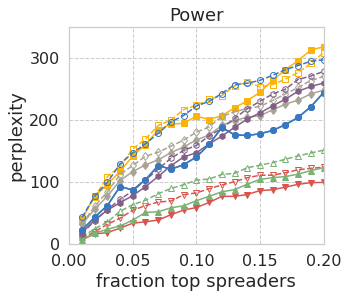

In [21]:
fig = plt.figure(figsize = (5,4.3))

plt.plot(node_fractions, mec_perp,        marker = "o", color = sb.color_palette()[0], label = "map equation centrality")
plt.plot(node_fractions, mod_vit_perp,    marker = "s", color = sb.color_palette()[1], label = "modularity vitality")
plt.plot(node_fractions, mod_vit_pr_perp, marker = "s", color = sb.color_palette()[1], linestyle = "--", fillstyle = "none")
plt.plot(node_fractions, com_hb_perp,     marker = "v", color = sb.color_palette()[2], label = "community hub-bridge")
plt.plot(node_fractions, com_hb_pr_perp,  marker = "v", color = sb.color_palette()[2], linestyle = "--", fillstyle = "none")
plt.plot(node_fractions, com_bc_perp,     marker = "^", color = sb.color_palette()[4], label = "comm.-based centrality")
plt.plot(node_fractions, com_bc_pr_perp,  marker = "^", color = sb.color_palette()[4], linestyle = "--", fillstyle = "none")
plt.plot(node_fractions, dc_perp,         marker = "d", color = sb.color_palette()[3], label = "degree centrality")
plt.plot(node_fractions, dc_perp_pr,      marker = "d", color = sb.color_palette()[3], linestyle = "--", fillstyle = "none")
plt.plot(node_fractions, between_perp,    marker = "h", color = sb.color_palette()[5], label = "betweenness centrality")
plt.plot(node_fractions, between_perp_pr, marker = "h", color = sb.color_palette()[5], linestyle = "--", fillstyle = "none")
plt.plot(node_fractions, mec_perp,        marker = "o", color = sb.color_palette()[0])
plt.plot(node_fractions, mec_pr_perp,     marker = "o", color = sb.color_palette()[0], linestyle = "--", fillstyle = "none")

plt.title("Power", fontsize = 18)
plt.ylabel("perplexity", fontsize = 18)
plt.xlabel("fraction top spreaders", fontsize = 18)
plt.xticks([0,0.05,0.1,0.15,0.2], fontsize = 16)
plt.yticks([0,100,200,300], fontsize = 16)
plt.xlim(0.0, 0.2)
plt.ylim(0,350)
plt.tight_layout()
plt.savefig("../plots/perplexity-power.pdf")

In [22]:
!pdfcrop ../plots/perplexity-power.pdf
!mv ../plots/perplexity-power-crop.pdf ../plots/perplexity-power.pdf

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../plots/perplexity-power-crop.pdf'.
